In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import os

In [2]:
network = pypsa.examples.scigrid_de()

INFO:mip.model:Using Python-MIP package version 1.15.0
INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


# CREATE 2024 ISP WITH PYPSA!!!


In [54]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import os
import re

n = pypsa.Network()

start = (2025,1,1)
end = (2025,1,2)

# Carriers

for fuel in ['Black Coal', 'Brown Coal', 'Gas', 'Liquid Fuel', 'Water', 'Solar', 'Wind', 'Battery']:
    n.add('Carrier',name=fuel)

n.add("Carrier", "AC", co2_emissions=0.0)
n.add("Carrier", "DC", co2_emissions=0.0)

# Test on first month
n.set_snapshots(pd.date_range(start=f"{start[0]}-{start[1]}-{start[2]} 00:00",end=f"{end[0]}-{end[1]}-{end[2]} 23:30",freq='30min'))

path = "./isp_sheets/"

In [ ]:
# Buses

busdf = pd.read_csv(path + "network_representation/subregional_ref_nodes.csv")

for _,row in busdf.iterrows():
    n.add('Bus',row['Bus'],v_nom=row['Voltage (kV)'],carrier='AC')

In [56]:
# Links

# try lines too
# links for DC and other abstract ties but lines for ac

linkdf = pd.read_csv(path + "network_capability/flow_path_capability.csv")

for _,row in linkdf.iterrows():
    n.add("Link",row['Plain Name'],
          bus0 = row['Bus0'],
          bus1 = row['Bus1'],
        #   type = "AC",
          carrier='AC',
          p_nom = row['Max forward'],
          p_min_pu = -row['Max reverse']/row['Max forward'])
          # p_min_pu = -1)
    
# n.links.loc['NNSW-SQ Terranora','type'] = "DC"
# n.links.loc['VIC-CSA Murraylink','type'] = "DC"
# n.links.loc['TAS-VIC Basslink','type'] = "DC"
n.links.loc['NNSW-SQ Terranora','carrier'] = "DC"
n.links.loc['VIC-CSA Murraylink','carrier'] = "DC"
n.links.loc['TAS-VIC Basslink','carrier'] = "DC"

In [57]:
# Generators

def is_DUID(s):
    '''more to make sure it's not a rez'''
    pattern = r'^(?=.*[A-Z])(?=.*\d)[A-Z0-9]+$'
    return bool(re.match(pattern, s))

def get_trace_fn(trName,files):
    for fn in files:
        if fn.startswith(trName):
            return fn

solarTraces = os.listdir("../Downloads/Solar/")
solarTraceNames = [s.split("_")[0] for s in solarTraces if s[:3]!="REZ"]

windTraces = os.listdir("../Downloads/Wind/")
windTraceNames = [s.split("_")[0] for s in windTraces if len(s.split("_")[0])>2]

# hydro = pd.read_csv("../Desktop/2024 ISP Model/Traces/hydro")
# add hydro constraints

trace_map = pd.read_csv(path + "summary_mapping/trace_map.csv")
traceMap  = trace_map.set_index('GenName')['TraceName'].to_dict()

# do this better
# currently only using existing_gens for Generator name :/
existing_gens = pd.read_csv(path + "maximum_capacity/existing_gen_caps.csv")
existing_map  = pd.read_csv(path + "summary_mapping/existing.csv",index_col=0)
existing_summary  = pd.read_csv(path + "generation_summary/existing_gen_summary.csv",index_col=0)
existing_units  = pd.read_csv(path + "seasonal_ratings/existing_gen_seasonal_ratings.csv")

# for fuel in existing_map['Fuel type'].unique():
#     n.add('Carrier',name=fuel)

# add gens
# consider adding project status as part of carrier info
year = 2025 # financial
for idx,row in existing_gens.iterrows():
    genName = row['Generator']
    fuel = existing_map.loc[genName,"Fuel type"]
    busName = existing_summary.loc[genName,"ISP sub-region"]
    marginalCost = existing_summary.loc[genName,"SRMC ($/MWh)"]

    units = existing_units[existing_units['Generator']==genName]

    for unit,urow in units.iterrows():
        unitName = urow['DUID']
        summerTypical = urow[f'ST{year-1}-{str(year)[2:]}']
        summerPeak = urow[f'SP{year-1}-{str(year)[2:]}']

        if fuel == 'Wind':
            df = pd.read_csv("../Downloads/Wind/"+get_trace_fn(traceMap[genName],windTraces))
            newdf = df.set_index(["Year","Month","Day"])
            p_max_pu_vals = newdf.loc[start:end].values.flatten()
            n.add("Generator",
                name = genName + ' (' + unitName + ')',
                bus  = busName,
                carrier = fuel,
                marginal_cost = marginalCost,
                p_nom = summerTypical,
                p_max_pu = p_max_pu_vals)
        elif fuel == 'Solar':
            df = pd.read_csv("../Downloads/Solar/"+get_trace_fn(traceMap[genName],solarTraces))
            newdf = df.set_index(["Year","Month","Day"])
            p_max_pu_vals = newdf.loc[start:end].values.flatten()
            n.add("Generator",
                name = genName + ' (' + unitName + ')',
                bus  = busName,
                carrier = fuel,
                marginal_cost = marginalCost,
                p_nom = summerTypical,
                p_max_pu = p_max_pu_vals)
        elif fuel == 'Water':
            n.add("Generator",
                name = genName + ' (' + unitName + ')',
                bus  = busName,
                carrier = fuel,
                marginal_cost = marginalCost,
                p_nom = summerTypical)
                # p_nom_max = summerPeak)
        elif fuel in ['Black Coal', 'Brown Coal', 'Gas', 'Liquid Fuel']:
            # outages are forced in manually using p_max_pu
            # randomly set p_max_pu to zero and include summer and winter differences
            n.add("Generator",
                name = genName + ' (' + unitName + ')',
                bus  = busName,
                carrier = fuel,
                marginal_cost = marginalCost,
                p_nom = summerTypical)
                # p_nom_max = summerPeak) 
                # pnommax ignored anyway unless pnomextendable is True
        else:
            print(genName)
            print("Something else")

In [58]:
# Load

demandpath = "../Desktop/2024 ISP Model/2024 ISP Step Change/Traces/demand/"
subregions = os.listdir(demandpath)

for subregion in subregions:
    fn = demandpath + subregion
    
    if fn.endswith('.csv'):
        df = pd.read_csv(demandpath + subregion)
        newdf = df.set_index(["Year","Month","Day"])
        demand = newdf.loc[start:end].values.flatten()
        bus = subregion.split('_')[0]

        n.add("Load",
              name=f"Load_{bus}",
              bus=bus,
              p_set=demand)


In [59]:
# Storage

# add batteries

battery = pd.read_csv("./isp_sheets/summary_mapping/batteries.csv",index_col=0)
battery_summary  = pd.read_csv(path + "generation_summary/battery_gen_summary.csv",index_col=0)
battery_ratings = pd.read_csv("./isp_sheets/seasonal_ratings/battery_gen_seasonal_ratings.csv")
battery_caps = pd.read_csv("./isp_sheets/maximum_capacity/battery_caps.csv")

battery_caps['Max storage hours'] = battery_caps['Energy (MWh)'] / battery_caps['Installed capacity (MW)']
battery_caps_existing = battery_caps[battery_caps['Project status']=='Existing']
battery_caps_new = battery_caps[~(battery_caps['Project status']=='Existing')]

for idx,row in battery_caps_existing.iterrows():
    batName = row['Storage']
    fuel = battery.loc[batName,"Fuel type"]
    busName = battery_summary.loc[batName,"ISP sub-region"]
    marginalCost = battery_summary.loc[batName,"SRMC ($/MWh)"]
    
    units = battery_ratings[battery_ratings['Generator']==batName]

    for unit,urow in units.iterrows():
        unitName = urow['DUID']
        summerTypical = urow[f'ST{year-1}-{str(year)[2:]}']

        n.add("StorageUnit",
                name = batName + ' (' + unitName + ')',
                bus  = busName,
                carrier = fuel,
                marginal_cost = marginalCost,
                p_nom = summerTypical,
                max_hours = row['Max storage hours'])

# add battery and pumped hydro properties

# find out which hydro gens also have pumped hydro -> phes_properties

# do Kidston manually MAKE SURE TO INCLUDE PUMP CAPACITY

# check REZ hosting capacity increase of NQ2

# has a different pump capacity to generation capacity


In [ ]:
# Transformers

n.add("Transformer",name="Transformer_NNSW_SQ",bus0='NNSW',bus1='SQ',x=0.1,r=0.01,s_nom = 1000)
n.add("Transformer",name="Transformer_SNSW_VIC",bus0='SNSW',bus1='VIC',x=0.1,r=0.01,s_nom = 1000)
n.add("Transformer",name="Transformer_SNSW_CSA",bus0='SNSW',bus1='CSA',x=0.1,r=0.01,s_nom = 1000)
n.add("Transformer",name="Transformer_SESA_VIC",bus0='SESA',bus1='VIC',x=0.1,r=0.01,s_nom = 1000)
n.add("Transformer",name="Transformer_SESA_CSA",bus0='SESA',bus1='CSA',x=0.1,r=0.01,s_nom = 1000)
n.add("Transformer",name="Transformer_VIC_TAS",bus0='VIC',bus1='TAS',x=0.1,r=0.01,s_nom = 1000)

Index(['Transformer_VIC_TAS'], dtype='object')

In [61]:
n.consistency_check()
n.optimize()

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 61.50it/s]
INFO:linopy.io: Writing time: 0.66s


Running HiGHS 1.9.0 (git hash: fa40bdf): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+01]
  Cost   [9e+00, 5e+02]
  Bound  [0e+00, 0e+00]
  RHS    [7e-04, 7e+03]
Presolving model
3168 rows, 45319 cols, 53363 nonzeros  0s
3052 rows, 11685 cols, 17309 nonzeros  0s
2480 rows, 10727 cols, 15684 nonzeros  0s
Presolve : Reductions: rows 2480(-101680); columns 10727(-39769); elements 15684(-143848)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.3487354503e+00 Pr: 2384(2.75764e+06) 0s
       4051     2.2651924316e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-eonw3pju
Model status        : Optimal
Simplex   iterations: 4051
Objective value     :  2.2651924316e+07
Relative P-D gap    :  1.8090380628e-15
HiGHS run time      :          0.33


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 50496 primals, 104160 duals
Objective: 2.27e+07
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


Writing the solution to /private/var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/linopy-solve-o92eyps5.sol


('ok', 'optimal')

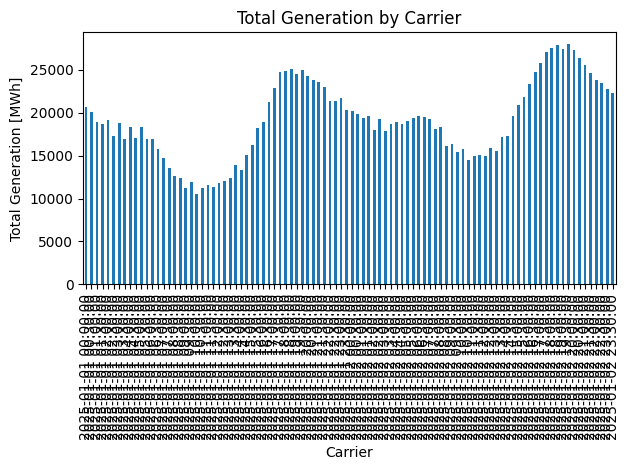

In [79]:
# Get per-generator dispatch (in MW) over time
gen = n.generators_t.p  # DataFrame: index=time, columns=generator names

# Map generator names to carriers
gen_carriers = n.generators['carrier']

# Group columns by carrier and sum
gen_by_carrier = gen.T.groupby(gen_carriers).sum()

# Sum over time to get total MWh for the entire period
total_gen_by_carrier = gen_by_carrier.sum()

# Plot
fig, ax = plt.subplots()
total_gen_by_carrier.plot(kind='bar', ax=ax)

ax.set_ylabel('Total Generation [MWh]')
ax.set_xlabel('Carrier')
ax.set_title('Total Generation by Carrier')
plt.tight_layout()
plt.show()

In [111]:
total_gen_by_carrier.sum()/1000

1839.2193415349998

In [104]:
hist = pd.read_csv("./isp_sheets/20240813_open_electricity.csv",index_col=0,parse_dates=True)
hist.head()

,Battery (Charging) - GWh,Pumps - GWh,Coal (Brown) - GWh,Coal (Black) - GWh,Bioenergy (Biomass) - GWh,Distillate - GWh,Gas (Steam) - GWh,Gas (CCGT) - GWh,Gas (OCGT) - GWh,Gas (Reciprocating) - GWh,...,Gas (Steam) Market Value - AUD,Gas (CCGT) Market Value - AUD,Gas (OCGT) Market Value - AUD,Gas (Reciprocating) Market Value - AUD,Gas (Waste Coal Mine) Market Value - AUD,Battery (Discharging) Market Value - AUD,Hydro Market Value - AUD,Wind Market Value - AUD,Solar (Utility) Market Value - AUD,Solar (Rooftop) Market Value - AUD
date,,,,,,,,,,,,,,,,,,,,,
2024-08-13,-3.19,-2.95,78.12,255.63,0.72,0.11,3.18,26.40,13.29,0.99,...,327875.98,3696069.33,2141653.25,164079.45,189593.31,453445.71,4265504.16,9504570.72,3136769.84,2207860.47
2024-08-14,-2.81,-2.51,79.13,262.41,0.88,0.11,3.97,28.58,21.10,1.45,...,511897.47,4387989.36,3727478.83,235937.55,175797.48,497951.91,5914309.28,7869493.83,2590912.16,2393843.81
2024-08-15,-3.29,-3.26,77.60,247.98,1.27,0.08,2.04,22.85,13.46,0.67,...,83844.24,3822265.38,3254052.71,90436.78,137279.63,587732.39,7920115.56,5062156.37,1903313.43,1466718.67
2024-08-16,-2.83,-3.91,82.65,244.77,0.96,0.00,2.59,20.62,12.14,0.90,...,179588.25,2784414.13,1893235.84,119964.21,149605.73,389565.29,4697183.92,8397815.96,2177542.40,2657972.36
2024-08-17,-2.58,-8.16,82.46,216.18,0.77,0.00,3.53,19.56,6.96,1.38,...,371928.47,2297945.96,854811.65,191097.79,74135.88,219574.05,3576595.37,8107761.77,7589.78,-221839.56


In [105]:
hist.loc['2025-01-01':'2025-01-02',hist.columns.str.contains(r"-  GWh")].sum()

Battery (Charging) -  GWh        -5.70
Pumps -  GWh                     -9.84
Coal (Brown) -  GWh             141.17
Coal (Black) -  GWh             452.92
Bioenergy (Biomass) -  GWh        2.98
Distillate -  GWh                 0.00
Gas (Steam) -  GWh                1.98
Gas (CCGT) -  GWh                13.07
Gas (OCGT) -  GWh                 2.05
Gas (Reciprocating) -  GWh        0.00
Gas (Waste Coal Mine) -  GWh      2.18
Battery (Discharging) -  GWh      4.12
Hydro -  GWh                     42.08
Wind -  GWh                     148.20
Solar (Utility) -  GWh          110.15
Solar (Rooftop) -  GWh          203.06
dtype: float64

In [112]:
hist.loc['2025-01-02',hist.columns.str.contains(r"-  GWh")]

Battery (Charging) -  GWh        -2.86
Pumps -  GWh                     -2.58
Coal (Brown) -  GWh              71.47
Coal (Black) -  GWh             222.85
Bioenergy (Biomass) -  GWh        1.11
Distillate -  GWh                 0.00
Gas (Steam) -  GWh                0.99
Gas (CCGT) -  GWh                 6.57
Gas (OCGT) -  GWh                 1.01
Gas (Reciprocating) -  GWh        0.00
Gas (Waste Coal Mine) -  GWh      1.09
Battery (Discharging) -  GWh      1.85
Hydro -  GWh                     19.67
Wind -  GWh                      83.29
Solar (Utility) -  GWh           56.59
Solar (Rooftop) -  GWh           88.99
Name: 2025-01-02 00:00:00, dtype: float64

In [113]:
hist.loc['2025-01-01',hist.columns.str.contains(r"-  GWh")]

Battery (Charging) -  GWh        -2.84
Pumps -  GWh                     -7.26
Coal (Brown) -  GWh              69.70
Coal (Black) -  GWh             230.07
Bioenergy (Biomass) -  GWh        1.87
Distillate -  GWh                 0.00
Gas (Steam) -  GWh                0.99
Gas (CCGT) -  GWh                 6.50
Gas (OCGT) -  GWh                 1.04
Gas (Reciprocating) -  GWh        0.00
Gas (Waste Coal Mine) -  GWh      1.09
Battery (Discharging) -  GWh      2.27
Hydro -  GWh                     22.41
Wind -  GWh                      64.91
Solar (Utility) -  GWh           53.56
Solar (Rooftop) -  GWh          114.07
Name: 2025-01-01 00:00:00, dtype: float64

In [114]:
558.38+550.04-2.84-7.26-2.86-2.58

1092.8800000000003

In [53]:
n.export_to_netcdf(path+"isp24_v1.nc")

INFO:pypsa.io:Exported network 'isp24_v1.nc' contains: carriers, buses, transformers, links, loads, generators, storage_units


<xarray.Dataset> Size: 548kB
Dimensions:                            (snapshots: 96, investment_periods: 0,
                                        carriers_i: 10, buses_i: 12,
                                        buses_t_p_i: 11, buses_t_q_i: 2,
                                        buses_t_v_mag_pu_i: 5,
                                        buses_t_v_ang_i: 7,
                                        buses_t_marginal_price_i: 12,
                                        ...
                                        generators_t_q_i: 2,
                                        storage_units_i: 20,
                                        storage_units_t_p_i: 20,
                                        storage_units_t_p_dispatch_i: 20,
                                        storage_units_t_p_store_i: 20,
                                        storage_units_t_state_of_charge_i: 20)
Coordinates: (12/29)
  * snapshots                          (snapshots) int64 768B 0 1 2 ... 93 94 95
  * investment_periods                 (investment_periods) int64 0B 
  * carriers_i                         (carriers_i) object 80B 'Black Coal' ....
  * buses_i                            (buses_i) object 96B 'NQ' 'CQ' ... 'TAS'
  * buses_t_p_i                        (buses_t_p_i) object 88B 'NQ' ... 'TAS'
  * buses_t_q_i                        (buses_t_q_i) object 16B 'SQ' 'VIC'
    ...                                 ...
  * generators_t_q_i                   (generators_t_q_i) object 16B 'Kogan C...
  * storage_units_i                    (storage_units_i) object 160B 'Adelaid...
  * storage_units_t_p_i                (storage_units_t_p_i) object 160B 'Ade...
  * storage_units_t_p_dispatch_i       (storage_units_t_p_dispatch_i) object 160B ...
  * storage_units_t_p_store_i          (storage_units_t_p_store_i) object 160B ...
  * storage_units_t_state_of_charge_i  (storage_units_t_state_of_charge_i) object 160B ...
Data variables: (12/55)
    snapshots_snapshot                 (snapshots) datetime64[ns] 768B 2025-0...
    snapshots_objective                (snapshots) float64 768B 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 768B 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 768B 1.0 1.0 ... 1.0
    investment_periods_objective       (investment_periods) object 0B 
    investment_periods_years           (investment_periods) object 0B 
    ...                                 ...
    storage_units_max_hours            (storage_units_i) float64 160B 2.167 ....
    storage_units_p_nom_opt            (storage_units_i) float64 160B 6.0 ......
    storage_units_t_p                  (snapshots, storage_units_t_p_i) float64 15kB ...
    storage_units_t_p_dispatch         (snapshots, storage_units_t_p_dispatch_i) float64 15kB ...
    storage_units_t_p_store            (snapshots, storage_units_t_p_store_i) float64 15kB ...
    storage_units_t_state_of_charge    (snapshots, storage_units_t_state_of_charge_i) float64 15kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           22676912.389549583
    network_objective_constant:  0
    network_pypsa_version:       0.32.1
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

In [120]:
mc = [29]*48 + [30]*48
mc

[29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30]

In [122]:
n.add("Bus",name="Extra",v_nom=220)

Index(['Extra'], dtype='object')

In [124]:
n.add("Generator",name="CCGT dynamic",bus='Extra',marginal_cost = [29]*48 + [30]*48,overwrite=True)

Index(['CCGT dynamic'], dtype='object', name='Generator')

In [125]:
n.generators_t.marginal_cost

Generator,CCGT dynamic
snapshot,
2025-01-01 00:00:00,29.0
2025-01-01 00:30:00,29.0
2025-01-01 01:00:00,29.0
2025-01-01 01:30:00,29.0
2025-01-01 02:00:00,29.0
...,...
2025-01-02 21:30:00,30.0
2025-01-02 22:00:00,30.0
2025-01-02 22:30:00,30.0


In [67]:
n.generators_t.p

Generator,Bayswater (BW01),Bayswater (BW02),Bayswater (BW03),Bayswater (BW04),Callide B (CALL_B_1),Callide B (CALL_B_2),Callide C (CPP_3),Callide C (CPP_4),Eraring (ER01),Eraring (ER02),...,Waterloo Wind Farm (WATERLWF),Wattle Point Wind Farm (WPWF),Waubra Wind Farm (WAUBRAWF),White Rock Wind Farm - Stage 1 (WRWF1),Willogoleche Wind Farm (WGWF1),Woodlawn Wind Farm (WOODLWN1),Woolnorth Wind Farm (WOOLNTH1),Yaloak South Wind Farm (YSWF1),Yambuk Wind Farm (YAMBUKWF),Yendon Wind Farm (YENDWF1)
snapshot,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,660.000000,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,68.69772,30.893681,10.828608,27.594304,39.079838,9.969360,35.97454,0.301165,1.25556,3.823970
2025-01-01 00:30:00,660.000000,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,60.31805,31.048017,10.821504,21.116268,33.263951,7.752192,37.19394,0.048546,0.73332,2.625471
2025-01-01 01:00:00,660.000000,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,51.89080,28.895048,9.629760,15.416016,36.135540,5.841120,36.68658,0.047270,0.42222,1.732788
2025-01-01 01:30:00,514.996097,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,42.23843,24.142209,9.029184,9.349232,33.890843,3.899808,36.78290,0.140389,0.14445,1.006094
2025-01-01 02:00:00,456.722801,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,34.67854,18.288179,-0.000000,1.609232,37.965284,1.788336,45.95444,0.042775,-0.00000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-02 21:30:00,660.000000,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,5.29672,32.339489,5.319744,79.917220,1.523200,17.655696,96.77654,2.356366,18.50001,8.251190
2025-01-02 22:00:00,660.000000,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,13.95251,32.880120,9.660672,74.772356,4.348736,14.416512,119.12040,3.267807,17.10000,9.896983
2025-01-02 22:30:00,660.000000,685.0,685.0,685.0,325.0,325.0,466.0,420.0,-0.0,-0.0,...,25.56970,32.880120,14.030784,64.599072,12.534508,8.070144,125.80148,2.962988,11.40000,12.980543


In [68]:
n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
CQ-NQ,CQ,NQ,,AC,1.0,True,0,inf,1400.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1400.0
CQ-GG,CQ,GG,,AC,1.0,True,0,inf,1050.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1050.0
SQ-CQ,SQ,CQ,,AC,1.0,True,0,inf,1100.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1100.0
NNSW-SQ QNI,NNSW,SQ,,AC,1.0,True,0,inf,745.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,745.0
NNSW-SQ Terranora,NNSW,SQ,,DC,1.0,True,0,inf,50.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,50.0
CNSW–NNSW QNI,CNSW,NNSW,,AC,1.0,True,0,inf,910.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,910.0
CNSW­–SNW North,CNSW,SNW,,AC,1.0,True,0,inf,4730.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,4730.0
CNSW–SNW South,CNSW,SNW,,AC,1.0,True,0,inf,2720.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2720.0
SNSW–CNSW VNI,SNSW,CNSW,,AC,1.0,True,0,inf,2950.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2950.0


In [69]:
# Join generator carrier info with dispatch
gen_carrier = n.generators.carrier
gen_dispatch = n.generators_t.p

# Sum over all snapshots by carrier
dispatch_by_carrier = gen_dispatch.T.groupby(gen_carrier).sum()
dispatch_by_carrier

snapshot,2025-01-01 00:00:00,2025-01-01 00:30:00,2025-01-01 01:00:00,2025-01-01 01:30:00,2025-01-01 02:00:00,2025-01-01 02:30:00,2025-01-01 03:00:00,2025-01-01 03:30:00,2025-01-01 04:00:00,2025-01-01 04:30:00,...,2025-01-02 19:00:00,2025-01-02 19:30:00,2025-01-02 20:00:00,2025-01-02 20:30:00,2025-01-02 21:00:00,2025-01-02 21:30:00,2025-01-02 22:00:00,2025-01-02 22:30:00,2025-01-02 23:00:00,2025-01-02 23:30:00
carrier,,,,,,,,,,,,,,,,,,,,,
Black Coal,8409.764486,7634.164301,7479.599974,7146.463165,7087.053788,6515.766302,6790.877944,6280.498240,6472.659476,6465.616531,...,12915.835530,13059.473067,12276.943433,11050.443867,10420.182886,9887.769315,9751.842466,9600.948871,8872.273188,8618.320082
Brown Coal,1627.611395,1937.573035,1057.357802,1369.547533,2163.081690,842.490994,1883.463492,542.777676,1752.819843,518.683963,...,4755.000000,4755.000000,4755.000000,4755.000000,4560.049478,4055.994190,3305.000000,3077.841939,2993.778604,2559.776874
Gas,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Liquid Fuel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Solar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,171.682216,2.180824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Water,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,...,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000,7780.000000
Wind,2911.897952,2723.052036,2582.476430,2447.528877,2169.962951,2176.260758,2302.667888,2373.139361,2321.306047,2329.628535,...,1850.825602,2387.954192,2534.163624,2763.885581,2826.793238,2966.171249,3045.173243,3033.335857,3103.380581,3354.018596


In [72]:
n.generators[n.generators['carrier']=='Solar']

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Adelaide Desalination Plant Solar Farm (ADPPV1),CSA,PQ,,11.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,11.0
Avonlie Solar Farm (AVLSF1),SNSW,PQ,,190.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,190.0
Bannerton Solar Park (BANN1),VIC,PQ,,84.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,84.0
Beryl Solar Farm (BERYLSF1),CNSW,PQ,,83.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,83.0
Bluegrass Solar Farm (BLUEGSF1),SQ,PQ,,144.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whitsunday Solar Farm (WHITSF1),CQ,PQ,,55.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,55.0
Winton Solar Farm (WINTSF1),VIC,PQ,,85.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,85.0
Wyalong Solar Farm (WYASF1),SNSW,PQ,,53.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,53.0


In [73]:
n.storage_units

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Adelaide Desalination Plant BESS (ADPBA1G),CSA,PQ,,6.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.166667,1.0,1.0,0.0,0.0,6.0
Ballarat Energy Storage System (BALBG1),VIC,PQ,,30.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,1.000000,1.0,1.0,0.0,0.0,30.0
Bolivar Waste Water Treatment BESS (BOWWBA1G),CSA,PQ,,2.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.500000,1.0,1.0,0.0,0.0,2.0
Bouldercombe Battery project (BBATTERY),CQ,PQ,,50.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.000000,1.0,1.0,0.0,0.0,50.0
Bulgana Green Power Hub BESS (BULBESG1),VIC,PQ,,20.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,1.700000,1.0,1.0,0.0,0.0,20.0
Christies Beach Wastewater Treatment Plant BESS (CBWWBA1G),CSA,PQ,,2.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.000000,1.0,1.0,0.0,0.0,2.0
Dalrymple BESS (DALNTH01),CSA,PQ,,30.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,0.300000,1.0,1.0,0.0,0.0,30.0
Darlington Point Energy Storage System (DPNTBG1),SNSW,PQ,,25.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.000000,1.0,1.0,0.0,0.0,25.0
Gannawarra Energy Storage System (GANNBG1),VIC,PQ,,25.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.000000,1.0,1.0,0.0,0.0,25.0


In [76]:
# Locational Marginal Prices ($/MWh)
print(n.buses_t.marginal_price)

# Generator dispatch (MW)
print(n.generators_t.p)

# Total cost by generator
print((n.generators_t.p * n.generators.marginal_cost).sum(axis=0))

                       GG   NNSW   SESA    SNW    VIC    CSA   SNSW    TAS  \
snapshot                                                                     
2025-01-01 00:00:00  31.4  29.56  14.02  29.56  14.02  14.02  14.02  14.02   
2025-01-01 00:30:00  31.4  29.56  14.02  29.56  14.02  14.02  14.02  14.02   
2025-01-01 01:00:00  31.4  29.56  14.02  29.56  14.02  14.02  14.02  14.02   
2025-01-01 01:30:00  31.4  29.07  14.02  29.07  14.02  14.02  14.02  14.02   
2025-01-01 02:00:00  31.4  29.07  14.02  29.07  14.02  14.02  14.02  14.02   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
2025-01-02 21:30:00  31.4  31.40  15.23  30.34  15.23  15.23  15.23  15.23   
2025-01-02 22:00:00  31.4  31.37  15.23  30.34  15.23  15.23  15.23  15.23   
2025-01-02 22:30:00  31.4  31.37  14.31  30.34  14.31  14.31  14.31  14.31   
2025-01-02 23:00:00  31.4  31.37  14.31  30.34  14.31  14.31  14.31  14.31   
2025-01-02 23:30:00  31.4  29.56  14.31  29.56  14.31  14.31  14

In [ ]:
m = n.optimize.create_model()
# for adding your own pyomo constraints

Index(['NQ-CQ'], dtype='object', name='Link')
Index(['NQ-CQ'], dtype='object', name='Link')


IndexError: list index out of range